In [ ]:
#this code is referenced from the official tutorial

# Object Detection

In this tutorial, you will learn:
- to perform inference with a MMDetection detector.
- to train a new detector with a new dataset.

before start, revise line 9 in mmdetection/mmdet/__init__.py <br>
make it  <br>
mmcv_maximum_version = '2.2.1'

In [6]:
cd mmdetection

/home/test/MMdet/mmdetection


## Import MMDetection

In [2]:
from mmengine.utils import get_git_hash
from mmengine.utils.dl_utils import collect_env as collect_base_env

import mmdet
def collect_env():
    """Collect the information of the running environments."""
    env_info = collect_base_env()
    env_info['MMDetection'] = f'{mmdet.__version__}+{get_git_hash()[:7]}'
    return env_info


if __name__ == '__main__':
    for name, val in collect_env().items():
        print(f'{name}: {val}')

sys.platform: linux
Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
CUDA available: True
MUSA available: False
numpy_random_seed: 2147483648
GPU 0,1: NVIDIA GeForce RTX 5090
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 12.8, V12.8.93
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 2.8.0.dev20250422+cu128
PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90;-gencode;arch=compute_100,code=sm_1

In [3]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir ./checkpoint
!mkdir ./output

In [4]:
# there are plenty of models
# you may check what models are available on
# https://mmdetection.readthedocs.io/en/latest/modelzoo_statistics.html

### Inference the detector

Since the model is successfully created and loaded, let's see how good it is. We use the high-level API `DetInferencer` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/dev-3.x/mmdet/apis/det_inferencer.py).

In [3]:
import os
os.getcwd()

'/home/test/MMdet/mmdetection'

In [4]:
# load the pre-trained model
from mmdet.apis import init_detector
from mmengine import Config

# Load config file for the model
config_file = './configs/rtmdet/rtmdet_tiny_8xb32-300e_coco.py' # Example config path
config = Config.fromfile(config_file)

# Initialize detector with pre-trained weights, we just downloaded
checkpoint_file = './checkpoint/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth'  # Pre-trained weights
model = init_detector(config, checkpoint_file, device='cuda')

# Access model metadata
print(model.dataset_meta)

Loads checkpoint by local backend from path: ./checkpoint/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

{'classes': ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwa

In [5]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# URL of the image
url = "https://as1.ftcdn.net/jpg/02/36/99/22/1000_F_236992283_sNOxCVQeFLd5pdqaKGh8DRGMZy7P4XKm.jpg"  # Direct URL to the image

# Fetch the image content
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.save('Cat.jpg')


/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/opt/miniconda3/envs/py310mmdet2/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


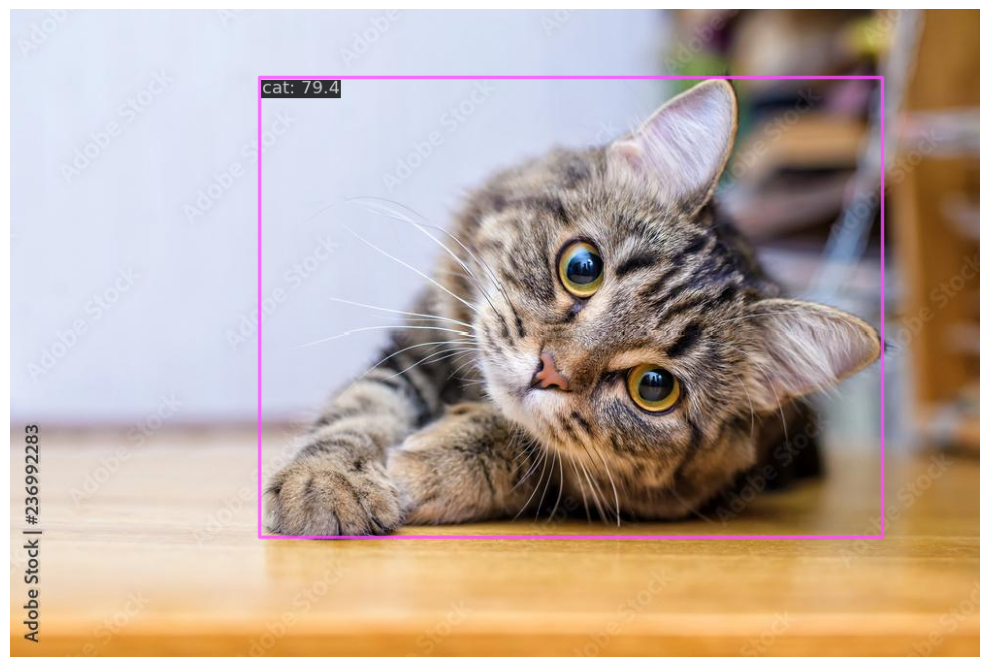

Detection Results:
Class: cat, Score: 0.7941, BBox: [256.9725646972656, 71.45645141601562, 897.7415161132812, 544.2039794921875]


In [6]:
# from the output of last line, we know the model can detect cat
# use the model to spot a cat
from mmdet.apis import inference_detector
import mmcv
import matplotlib.pyplot as plt
import numpy as np

# Run inference on a cat image, or any image you want
img_path = 'Cat.jpg'
result = inference_detector(model, img_path)

# Visualize the results
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

# Get class names from metadata
class_names = model.dataset_meta.get('classes', None)
threshold = 0.5

# Visualize detection results
from mmdet.visualization import DetLocalVisualizer
visualizer = DetLocalVisualizer()
visualizer.dataset_meta = model.dataset_meta
visualizer.add_datasample(
    'result',
    img,
    data_sample=result,
    draw_gt=False,
    wait_time=0,
    show=True,
    pred_score_thr=threshold  # Score threshold for detections
)

# Alternative visualization approach
plt.figure(figsize=(10, 10))
plt.imshow(visualizer.get_image())
plt.axis('off')
plt.tight_layout()
plt.show()

# Print the prediction results
print("Detection Results:")
for label_id, score, bbox in zip(
    result.pred_instances.labels, 
    result.pred_instances.scores, 
    result.pred_instances.bboxes
):
    if score>threshold:
        class_name = class_names[label_id]
        print(f"Class: {class_name}, Score: {score:.4f}, BBox: {bbox.tolist()}")

In [7]:
# Show the structure of result dict
from rich.pretty import pprint
pprint(result, max_length=4)

<DetDataSample(
│   
│   META INFORMATION
│   batch_input_shape: (640, 640)
│   scale_factor: (0.64, 0.6407185628742516)
│   ori_shape: (668, 1000)
│   img_shape: (640, 640)
│   img_id: 0
│   pad_shape: (640, 640)
│   img_path: 'Cat.jpg'
│   
│   DATA FIELDS
│   ignored_instances: <InstanceData(
│   │   │   
│   │   │   META INFORMATION
│   │   │   
│   │   │   DATA FIELDS
│   │   │   bboxes: tensor([], device='cuda:0', size=(0, 4))
│   │   │   labels: tensor([], device='cuda:0', dtype=torch.int64)
│   │   ) at 0x7bf41c5f8dc0>
│   gt_instances: <InstanceData(
│   │   │   
│   │   │   META INFORMATION
│   │   │   
│   │   │   DATA FIELDS
│   │   │   bboxes: tensor([], device='cuda:0', size=(0, 4))
│   │   │   labels: tensor([], device='cuda:0', dtype=torch.int64)
│   │   ) at 0x7bf41c5f8ca0>
│   pred_instances: <InstanceData(
│   │   │   
│   │   │   META INFORMATION
│   │   │   
│   │   │   DATA FIELDS
│   │   │   bboxes: tensor([[256.9726,  71.4565, 897.7415, 544.2040],
│   │   │   │   │   │   [  8.9677, 415.3114, 996.5376, 660.5349],
│   │   │   │   │   │   [  4.8012,  32.6302, 943.3939, 668.6636],
│   │   │   │   │   │   ...,
│   │   │   │   │   │   [846.2996,   0.0000, 943.6036, 128.9028],
│   │   │   │   │   │   [413.4257,   0.0000, 973.1343, 493.7211],
│   │   │   │   │   │   [579.3458, 349.5078, 725.9584, 485.1737]], device='cuda:0')
│   │   │   labels: tensor([15,  2, 13,  2, 13, 56, 41, 56, 58, 13, 58, 60, 56, 15, 56, 56, 60,  1,
│   │   │   │   │   │    2, 57, 58, 13, 63,  2, 56, 22, 58, 56,  1, 75, 41, 58, 56, 62,  1, 71,
│   │   │   │   │   │    1, 60, 59, 60, 56,  0, 60,  0, 41,  2,  2,  2, 39, 28, 73, 60, 60, 13,
│   │   │   │   │   │   71,  7,  0, 40, 13, 16, 72, 13, 57, 56, 57,  0, 13, 56, 45, 60, 57, 56,
│   │   │   │   │   │   25,  7,  0, 40, 60, 13,  0, 39, 41, 60, 56, 41,  0,  7, 41,  0, 56, 25,
│   │   │   │   │   │    0, 59, 56,  3,  2,  2, 69, 13,  2, 69, 62, 56,  0, 72, 39,  0,  0,  3,
│   │   │   │   │   │   50, 75,  3, 40, 13, 21, 60, 57, 41, 63,  7,  0,  5,  0, 40,  0,  0,  0,
│   │   │   │   │   │   59,  0, 56, 27,  3,  3, 28, 39, 13, 58, 56, 42, 63, 56, 56, 40,  0, 69,
│   │   │   │   │   │   39, 58, 56, 44,  7, 59, 75, 41, 56, 13, 45, 41, 26, 58,  2, 58, 34, 13,
│   │   │   │   │   │   58, 61, 62, 41, 56,  8,  1, 56, 13, 25,  2, 41, 56, 69,  9,  2, 62, 13,
│   │   │   │   │   │   28,  7,  6, 58,  7,  2, 41, 14, 59, 58, 68, 41, 41, 56, 58, 56,  1, 25,
│   │   │   │   │   │   42,  0, 26,  0,  0, 61,  1, 39, 15, 25, 62, 43, 17, 26,  2, 41,  0, 56,
│   │   │   │   │   │   39, 62, 69,  4, 41, 72, 60, 71, 40, 28,  2, 28, 15, 56, 61, 40, 66, 69,
│   │   │   │   │   │   43,  8, 58, 56, 58, 66, 39,  2, 60, 79, 45, 44, 56,  2,  0,  8,  8, 60,
│   │   │   │   │   │   56, 39,  0,  5, 13, 36, 39, 63,  2, 26,  9, 58,  0, 41, 34,  0, 45, 39,
│   │   │   │   │   │    8, 56, 56, 24,  0, 60,  0, 40, 39, 73,  0, 39, 72, 73,  0, 41, 60, 56,
│   │   │   │   │   │   15, 46, 39, 25,  0, 57,  0,  2, 15,  0, 58, 46], device='cuda:0')
│   │   │   scores: tensor([0.7941, 0.2064, 0.1613, 0.1462, 0.1453, 0.1431, 0.1392, 0.1281, 0.1184,
│   │   │   │   │   │   0.1101, 0.1087, 0.1034, 0.1005, 0.1002, 0.0967, 0.0958, 0.0943, 0.0916,
│   │   │   │   │   │   0.0886, 0.0854, 0.0844, 0.0824, 0.0816, 0.0815, 0.0806, 0.0792, 0.0779,
│   │   │   │   │   │   0.0772, 0.0769, 0.0762, 0.0755, 0.0749, 0.0747, 0.0743, 0.0738, 0.0700,
│   │   │   │   │   │   0.0688, 0.0666, 0.0656, 0.0656, 0.0648, 0.0647, 0.0643, 0.0640, 0.0631,
│   │   │   │   │   │   0.0622, 0.0622, 0.0622, 0.0617, 0.0610, 0.0609, 0.0608, 0.0604, 0.0601,
│   │   │   │   │   │   0.0598, 0.0589, 0.0589, 0.0586, 0.0581, 0.0579, 0.0574, 0.0572, 0.0559,
│   │   │   │   │   │   0.0550, 0.0543, 0.0538, 0.0537, 0.0531, 0.0526, 0.0525, 0.0521, 0.0520,
│   │   │   │   │   │   0.0518, 0.0516, 0.0515, 0.0508, 0.0507, 0.0501, 0.0495, 0.0491, 0.0486,
│   │   │   │   │   │   0.0485, 0.0482, 0.0481, 0.0479, 0.0475, 0.0471, 0.0468, 0.0467, 0.0464,
│   │   │   │   │   │   0.0464, 0.0457, 0.0

## Train with customized datasets

In this part, you will know how to train predefined models with customized datasets and then test it. We use the [balloon dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon) as an example to describe the whole process.

The basic steps are as below:

1. Prepare the customized dataset
2. Prepare a config
3. Train, test, and infer models on the customized dataset.


### Prepare the customized dataset

There are three ways to support a new dataset in MMDetection:

1. Reorganize the dataset into COCO format.
2. Reorganize the dataset into a middle format.
3. Implement a new dataset.

Usually, we recommend using the first two methods which are usually easier than the third.

In this tutorial, we use the ballon dataset an example of converting the data into COCO format.

**Note**: Datasets and metrics have been decoupled except CityScapes since MMDetection 3.0. Therefore, users can use any kind of evaluation metrics for any format of datasets during validation. For example: evaluate on COCO dataset with VOC metric, or evaluate on OpenImages dataset with both VOC and COCO metrics.

In [9]:
# Download the data and unzip it
%run ./tools/misc/download_dataset.py --dataset-name balloon --save-dir data --unzip

Unzipping balloon_dataset.zip


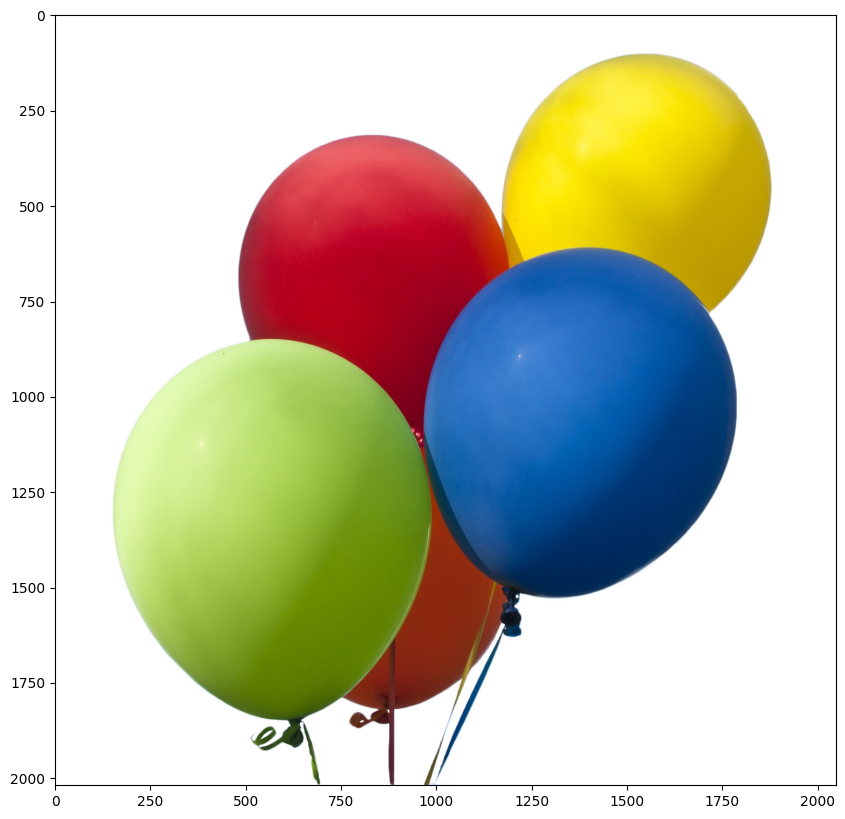

In [7]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('data/balloon/train/10464445726_6f1e3bbe6a_k.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

#### COCO annotation format
The necessary keys of COCO format for instance segmentation are as below, for the complete details, please refer [here](https://cocodataset.org/#format-data).
This case we only do detection, so "segmentation" can be set to None.

```json
{
    "images": [image],
    "annotations": [annotation],
    "categories": [category]
}
image = {
    "id": int,
    "width": int,
    "height": int,
    "file_name": str,
}
annotation = {
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height], # (x, y) are the coordinates of the upper left corner of the bbox
    "iscrowd": 0 or 1,
}
categories = [{
    "id": int,
    "name": str,
    "supercategory": str,
}]
```

Assume we use the balloon dataset.
After downloading the data, we need to implement a function to convert the annotation format into the COCO format. Then we can use implemented `CocoDataset` to load the data and perform training and evaluation.

If you take a look at the dataset, you will find the dataset format is as below:

```json
{'base64_img_data': '',
 'file_attributes': {},
 'filename': '34020010494_e5cb88e1c4_k.jpg',
 'fileref': '',
 'regions': {'0': {'region_attributes': {},
   'shape_attributes': {'all_points_x': [1020,
     1000,
     994,
     1003,
     1023,
     1050,
     1089,
     1134,
     1190,
     1265,
     1321,
     1361,
     1403,
     1428,
     1442,
     1445,
     1441,
     1427,
     1400,
     1361,
     1316,
     1269,
     1228,
     1198,
     1207,
     1210,
     1190,
     1177,
     1172,
     1174,
     1170,
     1153,
     1127,
     1104,
     1061,
     1032,
     1020],
    'all_points_y': [963,
     899,
     841,
     787,
     738,
     700,
     663,
     638,
     621,
     619,
     643,
     672,
     720,
     765,
     800,
     860,
     896,
     942,
     990,
     1035,
     1079,
     1112,
     1129,
     1134,
     1144,
     1153,
     1166,
     1166,
     1150,
     1136,
     1129,
     1122,
     1112,
     1084,
     1037,
     989,
     963],
    'name': 'polygon'}}},
 'size': 1115004}
```

The annotation is a JSON file where each key indicates an image's all annotations.
The code to convert the balloon dataset into coco format is as below.

Using the function below, users can successfully convert the annotation file into json format, then we can use `CocoDataset` to train and evaluate the model with `CocoMetric`.

In [10]:
import os.path as osp
import mmcv
from mmengine.fileio import dump, load
from mmengine.utils import track_iter_progress

def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = load(ann_file)

    annotations = []
    images = []
    obj_count = 0
    data_infos = list(data_infos.values())
    for idx, v in enumerate(track_iter_progress(data_infos)):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(
            dict(id=idx, file_name=filename, height=height, width=width))

        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            #poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)] # we dont need poly when doing detection
            #poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (min(px), min(py), max(px), max(py))

            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                #segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{
            'id': 0,
            'name': 'balloon'
        }])
    dump(coco_format_json, out_file)

convert_balloon_to_coco(ann_file='data/balloon/train/via_region_data.json',
                        out_file='data/balloon/train.json',
                        image_prefix='data/balloon/train')
convert_balloon_to_coco(ann_file='data/balloon/val/via_region_data.json',
                        out_file='data/balloon/val.json',
                        image_prefix='data/balloon/val')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 61/61, 333.3 task/s, elapsed: 0s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 402.9 task/s, elapsed: 0s, ETA:     0s


## Prepare a config

The second step is to prepare a config thus the dataset could be successfully loaded. Assume that we want to use RTMDet-tiny, the config to train the detector on balloon dataset is as below. Assume the config is under directory `configs/rtmdet/` and named as `rtmdet_tiny_1xb4-20e_balloon.py`, the config is as below.


In [11]:
# set configs for our model
# please revise the details inside for your task, take attention to #
# if you have no idea how to revise, just set %run tools/train.py configs/rtmdet/rtmdet_tiny_1xb4-20e.py first
# it will generate the used configs in work_dirs/
# then, you can copy the part that need to be revised and edit on it
# for more augmentation, you can refer to
# https://mmdetection.readthedocs.io/en/v2.19.1/tutorials/data_pipeline.html
# https://mmdetection.readthedocs.io/en/v2.16.0/_modules/mmdet/datasets/pipelines/transforms.html
# for mixup and mosaic
# https://mmdetection.readthedocs.io/en/latest/advanced_guides/how_to.html#use-mosaic-augmentation

config_balloon = """
# set model name
_base_ = './rtmdet_tiny_8xb32-300e_coco.py'

# dataset location
data_root = 'data/balloon/'

# Training parameters, set according to you device capacity
train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 20
stage2_num_epochs = 1
base_lr = 0.00008

metainfo = {
    'classes': ('balloon', ), # names of classes
    'palette': [              # any color you want
        (220, 20, 60),
    ]
}

# customed augmentation
a_transforms = [
    dict(
        type='OneOf',
        transforms=[
            dict(type='CLAHE', clip_limit=4.0, tile_grid_size=(8, 8), p=1.0),
            dict(type='ColorJitter', brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0),
            dict(type='RandomBrightnessContrast', brightness_limit=0.2, contrast_limit=0.2, p=1.0),
            dict(type='Equalize', p=1.0),
        ],
        p=0.2),
    dict(
        type='OneOf',
        transforms=[
            dict(type='Blur', blur_limit=3, p=1.0),
            dict(type='MedianBlur', blur_limit=3, p=1.0),
        ],
        p=0.2),
    dict(
        type='OneOf',
        transforms=[
            dict(type='ElasticTransform', alpha=1.0, sigma=50.0, p=1.0),
            dict(type='GridDistortion', p=1.0),
            dict(type='OpticalDistortion', distort_limit=0.05, p=1.0),
        ],
        p=0.2),
    dict(  
        type='BBoxSafeRandomCrop',
        erosion_rate=0.0,
        p=0.2), 
]
train_pipeline=[
    dict(backend_args=None, type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_label=True),
    dict(
        img_scale=(
            640,
            640,
        ),
        max_cached_images=20,
        pad_val=114.0,
        random_pop=False,
        type='CachedMosaic'),
    dict(
        keep_ratio=True,
        ratio_range=(
            0.5,
            2.0,
        ),
        scale=(
            1280,
            1280,
        ),
        type='RandomResize'),
    dict(crop_size=(
        640,
        640,
    ), type='RandomCrop'),
    dict(type='YOLOXHSVRandomAug'),
    dict(prob=0.5, type='RandomFlip'),
    dict(
        pad_val=dict(img=(
            114,
            114,
            114,
        )),
        size=(
            640,
            640,
        ),
        type='Pad'),
    dict(
        img_scale=(
            640,
            640,
        ),
        max_cached_images=10,
        pad_val=(
            114,
            114,
            114,
        ),
        prob=0.5,
        random_pop=False,
        ratio_range=(
            1.0,
            1.0,
        ),
        type='CachedMixUp'),
    dict(type='PackDetInputs'),
]

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/'),
        ann_file='train.json',
        pipeline=train_pipeline))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/'),
        ann_file='val.json'))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val.json')

test_evaluator = val_evaluator

model = dict(bbox_head=dict(num_classes=1)) # number of classes 

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        # use cosine lr from 10 to 20 epoch
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    checkpoint=dict(
        interval=5,
        max_keep_ckpts=2,  
        save_best='auto'
    ),
    logger=dict(type='LoggerHook', interval=5))

# load pre-trained weight
load_from = './checkpoint/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'),dict(type='TensorboardVisBackend')])
"""
# here we create the config file, you may rename it
with open('./configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py', 'w') as f:
    f.write(config_balloon)

In [ ]:
'''
You can also use Albumentations,
but for tranformations (that affect coordinates), if mmdet has the function you want already, it is safer the stick to mmdet due to compatibility concern

add this script to above code, 
right above 
train_pipeline = [
    dict(type='LoadImageFromFile'),
    
a_transforms = [
    dict(
        type='OneOf',
        transforms=[
            dict(type='CLAHE', clip_limit=4.0, tile_grid_size=(8, 8), p=1.0),
            dict(type='ColorJitter', brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0),
            dict(type='RandomBrightnessContrast', brightness_limit=0.2, contrast_limit=0.2, p=1.0),
            dict(type='Equalize', p=1.0),
        ],
        p=0.2),
    dict(
        type='OneOf',
        transforms=[
            dict(type='Blur', blur_limit=3, p=1.0),
            dict(type='MedianBlur', blur_limit=3, p=1.0),
        ],
        p=0.2),
    dict(
        type='OneOf',
        transforms=[
            dict(type='ElasticTransform', alpha=1.0, sigma=50.0, p=1.0),
            dict(type='GridDistortion', p=1.0),
            dict(type='OpticalDistortion', distort_limit=0.05, p=1.0),
        ],
        p=0.2),
    dict(  
        type='BBoxSafeRandomCrop',
        erosion_rate=0.0,
        p=0.2), 
]

and insert 
    dict(
        type='Albu',
        transforms=a_transforms,
        bbox_params=dict(
            type='BboxParams',
            format='pascal_voc', 
            label_fields=['gt_bboxes_labels', 'gt_ignore_flags'],
            min_visibility=0.0,
            filter_lost_elements=True,
            clip=True),
        keymap={
            'img': 'image',
            'gt_masks': 'masks',
            'gt_bboxes': 'bboxes'
        },
        skip_img_without_anno=False
    ),
right after
train_pipeline = [
    dict(type='LoadImageFromFile'),

'''

In [16]:
%run tools/train.py configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py

04/23 11:32:35 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1547251768
    GPU 0,1: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.8.0.dev20250422+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=comp

/home/test/MMdet/mmengine/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


04/23 11:32:37 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
04/23 11:32:37 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(49          ) EMAHook                            
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
after_load_checkpoint:
(49          ) EMAHook                            
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(49          ) EMAHook                            
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
(NORMAL      ) PipelineSwitchHoo

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmengine/mmengine/logging/message_hub.py:346: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  value = value.item()


04/23 11:32:40 - mmengine - INFO - Epoch(train)  [1][ 5/16]  base_lr: 3.5556e-05 lr: 3.5556e-05  eta: 0:00:49  time: 0.1577  data_time: 0.0458  memory: 1340  loss: 2.7315  loss_cls: 2.0277  loss_bbox: 0.7038
04/23 11:32:40 - mmengine - INFO - Epoch(train)  [1][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:33  time: 0.1066  data_time: 0.0237  memory: 1346  loss: 2.7188  loss_cls: 2.0084  loss_bbox: 0.7104
04/23 11:32:40 - mmengine - INFO - Epoch(train)  [1][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:26  time: 0.0877  data_time: 0.0162  memory: 1353  loss: 2.7281  loss_cls: 2.0214  loss_bbox: 0.7067
04/23 11:32:40 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250423_113235
04/23 11:32:41 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


04/23 11:32:42 - mmengine - INFO - Epoch(train)  [2][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:25  time: 0.0861  data_time: 0.0169  memory: 1345  loss: 2.7183  loss_cls: 2.0106  loss_bbox: 0.7077
04/23 11:32:42 - mmengine - INFO - Epoch(train)  [2][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:23  time: 0.0795  data_time: 0.0139  memory: 1341  loss: 2.7093  loss_cls: 2.0020  loss_bbox: 0.7072
04/23 11:32:42 - mmengine - INFO - Epoch(train)  [2][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:21  time: 0.0748  data_time: 0.0119  memory: 1344  loss: 2.7237  loss_cls: 2.0264  loss_bbox: 0.6972
04/23 11:32:42 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250423_113235
04/23 11:32:42 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


04/23 11:32:46 - mmengine - INFO - Epoch(train)  [5][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:16  time: 0.0570  data_time: 0.0079  memory: 1343  loss: 2.7236  loss_cls: 2.0957  loss_bbox: 0.6280
04/23 11:32:46 - mmengine - INFO - Epoch(train)  [5][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:15  time: 0.0567  data_time: 0.0078  memory: 1351  loss: 2.7252  loss_cls: 2.1184  loss_bbox: 0.6068
04/23 11:32:46 - mmengine - INFO - Epoch(train)  [5][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:15  time: 0.0563  data_time: 0.0078  memory: 1352  loss: 2.6908  loss_cls: 2.0879  loss_bbox: 0.6029
04/23 11:32:46 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250423_113235
04/23 11:32:46 - mmengine - INFO - Saving checkpoint at 5 epochs
04/23 11:32:47 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumu

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


04/23 11:32:48 - mmengine - INFO - The best checkpoint with 0.0730 coco/bbox_mAP at 5 epoch is saved to best_coco_bbox_mAP_epoch_5.pth.


/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


04/23 11:32:49 - mmengine - INFO - Epoch(train)  [6][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:15  time: 0.0562  data_time: 0.0077  memory: 1359  loss: 2.6435  loss_cls: 2.0473  loss_bbox: 0.5962
04/23 11:32:49 - mmengine - INFO - Epoch(train)  [6][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:14  time: 0.0562  data_time: 0.0077  memory: 1361  loss: 2.6058  loss_cls: 2.0290  loss_bbox: 0.5768
04/23 11:32:50 - mmengine - INFO - Epoch(train)  [6][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:14  time: 0.0565  data_time: 0.0077  memory: 1349  loss: 2.5574  loss_cls: 1.9992  loss_bbox: 0.5582
04/23 11:32:50 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250423_113235
04/23 11:32:50 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


04/23 11:32:52 - mmengine - INFO - Epoch(train)  [7][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:13  time: 0.0568  data_time: 0.0072  memory: 1347  loss: 2.4796  loss_cls: 1.9367  loss_bbox: 0.5429
04/23 11:32:52 - mmengine - INFO - Epoch(train)  [7][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:13  time: 0.0572  data_time: 0.0073  memory: 1347  loss: 2.3868  loss_cls: 1.8602  loss_bbox: 0.5266
04/23 11:32:52 - mmengine - INFO - Epoch(train)  [7][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:13  time: 0.0569  data_time: 0.0073  memory: 1344  loss: 2.2717  loss_cls: 1.7644  loss_bbox: 0.5074
04/23 11:32:52 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250423_113235
04/23 11:32:53 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


04/23 11:32:54 - mmengine - INFO - Epoch(train)  [8][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:12  time: 0.0575  data_time: 0.0073  memory: 1348  loss: 2.1360  loss_cls: 1.6470  loss_bbox: 0.4890
04/23 11:32:55 - mmengine - INFO - Epoch(train)  [8][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:12  time: 0.0574  data_time: 0.0073  memory: 1345  loss: 2.0303  loss_cls: 1.5572  loss_bbox: 0.4730
04/23 11:32:55 - mmengine - INFO - Epoch(train)  [8][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:11  time: 0.0574  data_time: 0.0074  memory: 1345  loss: 1.9167  loss_cls: 1.4599  loss_bbox: 0.4569
04/23 11:32:55 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250423_113235
04/23 11:32:55 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


04/23 11:32:57 - mmengine - INFO - Epoch(train)  [9][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:11  time: 0.0586  data_time: 0.0082  memory: 1357  loss: 1.7969  loss_cls: 1.3607  loss_bbox: 0.4362
04/23 11:32:57 - mmengine - INFO - Epoch(train)  [9][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:11  time: 0.0583  data_time: 0.0080  memory: 1346  loss: 1.6772  loss_cls: 1.2575  loss_bbox: 0.4198
04/23 11:32:57 - mmengine - INFO - Epoch(train)  [9][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:10  time: 0.0578  data_time: 0.0080  memory: 1352  loss: 1.5852  loss_cls: 1.1723  loss_bbox: 0.4128
04/23 11:32:57 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250423_113235
04/23 11:32:58 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.559
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.614
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


04/23 11:33:03 - mmengine - INFO - Epoch(train) [12][ 5/16]  base_lr: 7.7107e-05 lr: 7.7107e-05  eta: 0:00:08  time: 0.0580  data_time: 0.0077  memory: 1353  loss: 1.2627  loss_cls: 0.8912  loss_bbox: 0.3715
04/23 11:33:03 - mmengine - INFO - Epoch(train) [12][10/16]  base_lr: 7.5513e-05 lr: 7.5513e-05  eta: 0:00:08  time: 0.0580  data_time: 0.0075  memory: 1345  loss: 1.2457  loss_cls: 0.8747  loss_bbox: 0.3710
04/23 11:33:03 - mmengine - INFO - Epoch(train) [12][15/16]  base_lr: 7.3596e-05 lr: 7.3596e-05  eta: 0:00:07  time: 0.0576  data_time: 0.0075  memory: 1343  loss: 1.2167  loss_cls: 0.8551  loss_bbox: 0.3616
04/23 11:33:03 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250423_113235
04/23 11:33:03 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


04/23 11:33:06 - mmengine - INFO - Epoch(train) [14][ 5/16]  base_lr: 6.1855e-05 lr: 6.1855e-05  eta: 0:00:06  time: 0.0588  data_time: 0.0091  memory: 1351  loss: 1.0888  loss_cls: 0.7467  loss_bbox: 0.3421
04/23 11:33:07 - mmengine - INFO - Epoch(train) [14][10/16]  base_lr: 5.8584e-05 lr: 5.8584e-05  eta: 0:00:06  time: 0.0591  data_time: 0.0091  memory: 1344  loss: 1.0662  loss_cls: 0.7258  loss_bbox: 0.3404
04/23 11:33:07 - mmengine - INFO - Epoch(train) [14][15/16]  base_lr: 5.5152e-05 lr: 5.5152e-05  eta: 0:00:05  time: 0.0586  data_time: 0.0092  memory: 1344  loss: 1.0557  loss_cls: 0.7260  loss_bbox: 0.3297
04/23 11:33:07 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250423_113235
04/23 11:33:07 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.19s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


04/23 11:33:09 - mmengine - INFO - Epoch(train) [15][ 5/16]  base_lr: 5.0871e-05 lr: 5.0871e-05  eta: 0:00:05  time: 0.0585  data_time: 0.0095  memory: 1355  loss: 1.0236  loss_cls: 0.6971  loss_bbox: 0.3265
04/23 11:33:09 - mmengine - INFO - Epoch(train) [15][10/16]  base_lr: 4.7206e-05 lr: 4.7206e-05  eta: 0:00:05  time: 0.0579  data_time: 0.0095  memory: 1348  loss: 1.0224  loss_cls: 0.6957  loss_bbox: 0.3267
04/23 11:33:09 - mmengine - INFO - Epoch(train) [15][15/16]  base_lr: 4.3492e-05 lr: 4.3492e-05  eta: 0:00:04  time: 0.0578  data_time: 0.0095  memory: 1344  loss: 0.9936  loss_cls: 0.6702  loss_bbox: 0.3235
04/23 11:33:09 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250423_113235
04/23 11:33:09 - mmengine - INFO - Saving checkpoint at 15 epochs
04/23 11:33:10 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accum

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


04/23 11:33:11 - mmengine - INFO - Epoch(train) [16][ 5/16]  base_lr: 3.9019e-05 lr: 3.9019e-05  eta: 0:00:04  time: 0.0583  data_time: 0.0098  memory: 1345  loss: 0.9743  loss_cls: 0.6554  loss_bbox: 0.3189
04/23 11:33:11 - mmengine - INFO - Epoch(train) [16][10/16]  base_lr: 3.5320e-05 lr: 3.5320e-05  eta: 0:00:04  time: 0.0568  data_time: 0.0082  memory: 1343  loss: 0.9622  loss_cls: 0.6470  loss_bbox: 0.3152
04/23 11:33:11 - mmengine - INFO - Epoch(train) [16][15/16]  base_lr: 3.1685e-05 lr: 3.1685e-05  eta: 0:00:03  time: 0.0567  data_time: 0.0082  memory: 1349  loss: 0.9533  loss_cls: 0.6413  loss_bbox: 0.3120
04/23 11:33:11 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250423_113235
04/23 11:33:11 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [19]:
import torch
#after training, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

In [9]:
# here we demo how to use another approach to test
from mmdet.apis import DetInferencer

# Choose a config that we used for training
config = './configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py'
# Setup a checkpoint file to load, input the location of best pth we trained
checkpoint = './work_dirs/rtmdet_tiny_1xb4-20e_balloon/best_coco_bbox_mAP_epoch_20.pth'
# Set the device to be used for evaluation
device = 'cuda'

# Initialize the DetInferencer
inferencer = DetInferencer(config, checkpoint, device)

# Use the detector to do inference, 
img = './data/balloon/val/5555705118_3390d70abe_b.jpg'
result = inferencer(img, out_dir='./output', pred_score_thr=0.5)

Loads checkpoint by local backend from path: ./work_dirs/rtmdet_tiny_1xb4-20e_balloon/best_coco_bbox_mAP_epoch_20.pth
05/21 10:43:12 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


Output()

/home/test/MMdet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)`
is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):

/home/test/MMdet/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
/home/test/MMdet/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.TensorboardVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


/home/test/MMdet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: 
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):

/opt/miniconda3/envs/py310mmdet2/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid:
in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at 
/pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

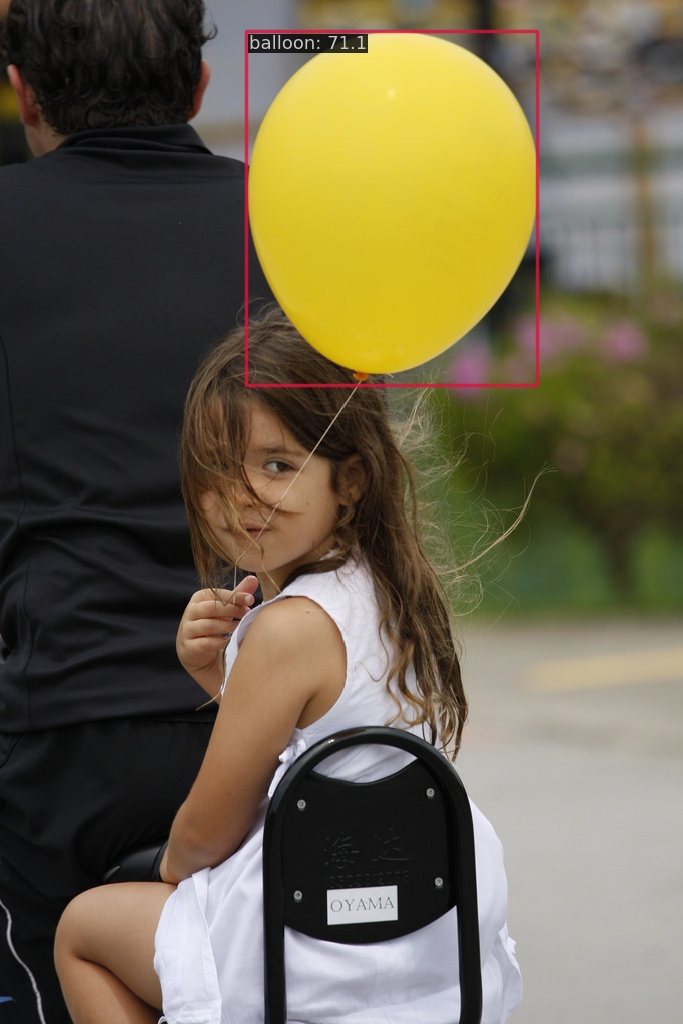

In [10]:
# Show the output image
from PIL import Image
Image.open('./output/vis/5555705118_3390d70abe_b.jpg')